## [사이킥런] Pima 인디언들의 당뇨병 데이터 셋을 활용한 데이터 분석
- [피마 인디언 당뇨병 데이트 셋](https://www.kaggle.com/uciml/pima-indians-diabetes-database)을 이용하여 당뇨병 여부를 판단하는 머신러닝 예측모델을 수립하고, 여러 평가 지표를 적용해본다.
- 특히 precision_recall_curv와 roc_auc_curve를 유의해서 사용해보자.

* Pregnancies: 임신 횟수
* Glucose: 포도당 부하 검사 수치
* BloodPressure: 혈압(mm Hg)
* SkinThickness: 팔 삼두근 뒤쪽의 피하지방 측정값(mm)
* Insulin: 혈청 인슐린(mu U/ml)
* BMI: 체질량지수 (체중(kg) / 키(m)^2)
* DiabetesPedigreeFunction: 당뇨 내력 가중치 값
* Age: 나이
* Outcome: 클래스 결정 값 (0 또는 1) --> target

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score,precision_score,recall_score, roc_curve, classification_report,precision_recall_curve
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Binarizer, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold

import warnings
warnings.filterwarnings(action="ignore")

### 1. DataFrame 확인

In [2]:
df = pd.read_csv("diabetes.csv")

print(df.shape)
print(df.info()) 
print(df.head())
print(df["Outcome"].value_counts())

(768, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2         

1. (768, 9) 모양
2. 결측치가 존재하지 않음
3. Object형 없음
4. 전체 768개의 데이터 중 Positive 값(1)은 268개, Negative 값(0)은 500개이다.

==> 따라서 Null 값과 문자열 처리를 위한 별도의 작업이 생략된다. 

In [3]:
# 1. 이상치 발견(0값)
# 2. 나이 --> 구간화
# 3. 편중된 데이터 정규화(스케일링/아웃라이어 삭제)
# 4. 타겟: Outcome(0/1)

X = df.drop("Outcome", axis=1)
y = df["Outcome"]
print(X.shape, y.shape)

(768, 8) (768,)


### 2. 히트맵을 통한 관계 확인하기

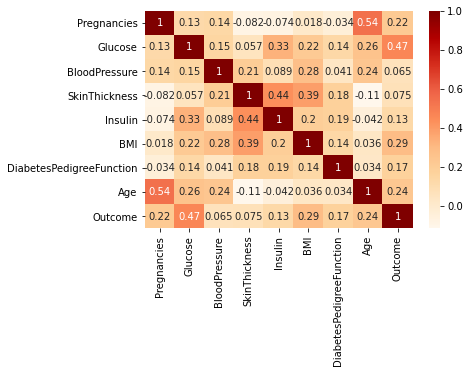

In [4]:
#-- 분석하기 좋은 데이터: // 정규화 하는 것은 자료가 좀 더 좋게 나오게 하는 것이다.
#-- 결측(X): isnull(), dropna(), fillna()
#-- Object(X): oh.Encoding()->(010...), pd.getDummy()--> 결측처리+인코딩(글자->수치)

sns.heatmap(df.corr(), annot=True, fmt=".2g", cmap="OrRd") #대략적인 관계 확인
plt.show()

* 상관분석 결과 Outcome과 비교하여 Glucose와 상관이 가장 높고 그 뒤로 BMI, Pregnancies 순으로 상관이 높다.
* 그 이외에 Age-Pregnancies, Age-Glucose, Insulin-Glucose, Insulin-SkinThickness , BMI-SkinThickness의 상관이 있으므로 유의해서 본다.

### 3. 예측 모델 만들기

In [5]:
def get_score(y_test, pred):
    acc = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    recall = recall_score(y_test, pred)
    precision = precision_score(y_test, pred)
    rocauc = roc_auc_score(y_test, pred)

    print("정확도:{:.4f}, F1:{:.4f} = (정밀도:{:.4f} + 재현률:{:.4f}), roc-auc:{:.4f}".format(acc, f1, recall, precision, rocauc))
    cf_matrix = confusion_matrix(y_test, pred)
    print(cf_matrix)

    # [[94  6]  #6  ==> 정밀도(예측P, 실제P) --> (fp): 예측은 당뇨(P)인데 실제론 정상(N)
    #  [19 35]] #19 ==> 재현률(실제P, 예측P) --> (fn): 실제론 당뇨(P)인데 예측이 정상(N)

#### 랜덤포레스트를 사용한 최초점수

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=121)

rf_model = RandomForestClassifier()

rf_model.fit(X_train, y_train)

pred = rf_model.predict(X_test)

get_score(y_test, pred)

정확도:0.8312, F1:0.7400 = (정밀도:0.6852 + 재현률:0.8043), roc-auc:0.7976
[[91  9]
 [17 37]]


* 별도의 데이터나 모델의 변경없이도 83.12%의 성능을 나타낸다.
* 다만, F1의 점수는 74.00로 높일 필요성이 있다.

### 3. 데이터 전처리(Data Preprocessing)
#### 스케일링/정규화, Object-->수치변환, 아웃라이어, 피쳐병합/삭제, 구간화(범주화)

#------------------------------------------  
* 아웃라이어/특이값 : 0값 처리
* 1.row 삭제  2.채우기(평균, 최빈도, 중위값)(V) 3.예측해서 채우기

#------------------------------------------  

In [ ]:
# fig, axes = plt.subplots(nrows=3, ncols=3)
# columns = df.columns
# for i, col in enumerate(columns) :
#     r = int(i / 3)
#     c = i % 3
#     sns.boxplot(x=col, y='Outcome', data=df, ax=axes[r][c])
# plt.show()

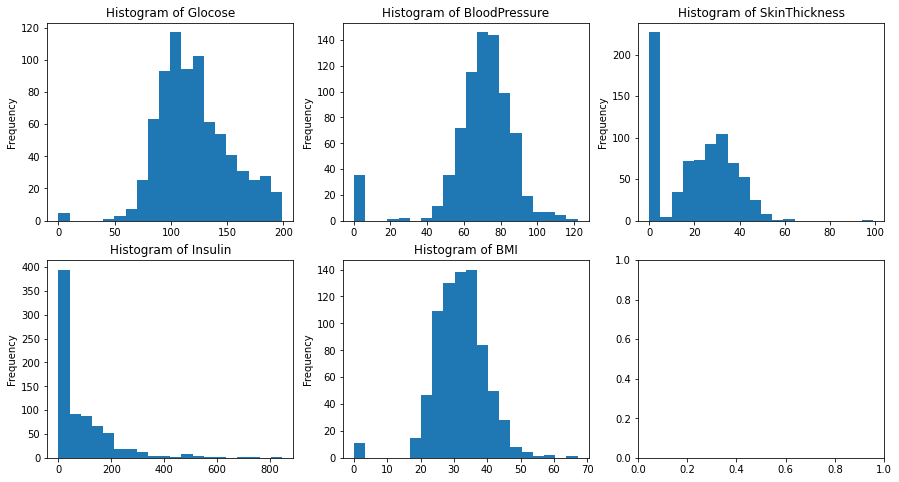

In [7]:
f, ax = plt.subplots(2, 3, figsize = (15, 8))
df['Glucose'].plot(kind = 'hist', bins = 20, ax = ax[0, 0])
ax[0,0].set_title('Histogram of Glocose')
df['BloodPressure'].plot(kind = 'hist', bins = 20, ax = ax[0, 1])
ax[0,1].set_title('Histogram of BloodPressure')
df['SkinThickness'].plot(kind = 'hist', bins = 20, ax = ax[0, 2])
ax[0,2].set_title('Histogram of SkinThickness')
df['Insulin'].plot(kind = 'hist', bins = 20, ax = ax[1, 0])
ax[1,0].set_title('Histogram of Insulin')
df['BMI'].plot(kind = 'hist', bins = 20, ax = ax[1, 1])
ax[1,1].set_title('Histogram of BMI')

plt.show()

* Pregnancies 111 --> 임신은 0인게 이상하지 않음
* Glucose 5 --> 이상
* BloodPressure 35 --> 이상
* SkinThickness 227 --> 이상
* Insulin 374 --> 이상
* BMI 11 --> 이상
* DiabetesPedigreeFunction 0 0.0 --> 문제 없음
* Age 0 0.0 --> 문제 없음

In [8]:
zero_column = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
zero_count = []
zero_percent = []
for col in zero_column:
  gcnt = X[X[col] ==0][col].count()
  zero_count.append(gcnt)
  zero_percent.append(np.round(gcnt/X.shape[0]*100, 2))

zero = pd.DataFrame([zero_count, zero_percent], 
                    columns = zero_column,
                    index = ['count', 'percent'])
print(zero)

         Glucose  BloodPressure  SkinThickness  Insulin    BMI
count       5.00          35.00         227.00    374.0  11.00
percent     0.65           4.56          29.56     48.7   1.43


#### 3-1. null값 처리 --> 중위값

In [9]:
zero_column_mean = X[zero_column].median().round(1)
X[zero_column] = X[zero_column].replace(0, zero_column_mean)

print(df[["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]].describe())

          Glucose  BloodPressure  SkinThickness     Insulin         BMI
count  768.000000     768.000000     768.000000  768.000000  768.000000
mean   120.894531      69.105469      20.536458   79.799479   31.992578
std     31.972618      19.355807      15.952218  115.244002    7.884160
min      0.000000       0.000000       0.000000    0.000000    0.000000
25%     99.000000      62.000000       0.000000    0.000000   27.300000
50%    117.000000      72.000000      23.000000   30.500000   32.000000
75%    140.250000      80.000000      32.000000  127.250000   36.600000
max    199.000000     122.000000      99.000000  846.000000   67.100000


#### 3-2. 아웃라이어/특이값(0) 처리 후 점수

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=121)
rf_model.fit(X_train, y_train)
pred = rf_model.predict(X_test)
get_score(y_test, pred)

정확도:0.8442, F1:0.7500 = (정밀도:0.6667 + 재현률:0.8571), roc-auc:0.8033
[[94  6]
 [18 36]]


최초점수와 비교하여 정확도와 F1값이 소폭 개선되었다.

#### 3-3. 나이 구간화(범주화) / 인코딩 25~75세

In [11]:
X['Age_cate'] = X['Age'].apply(lambda x : int(x//10))
X_encoding = pd.get_dummies(data=X, columns=["Age_cate"], prefix = "OH_Age_cate")  #, drop_first = True
print(X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    float64
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Age_cate                  768 non-null    int64  
dtypes: float64(3), int64(6)
memory usage: 54.1 KB
None


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=121)
rf_model.fit(X_train, y_train)
pred = rf_model.predict(X_test)
get_score(y_test, pred)

정확도:0.8571, F1:0.7843 = (정밀도:0.7407 + 재현률:0.8333), roc-auc:0.8304
[[92  8]
 [14 40]]


특이값 처리 때보다도 정확도와 F1값이 소폭 개선되었다.

#### 3-4. 스케일링/정규화 : RobustScaler, MinMaxScaler, StandardScaler

In [13]:
scaler = StandardScaler()
X_scaler = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaler, y, test_size=0.2, random_state=121)
rf_model.fit(X_train, y_train)
pred = rf_model.predict(X_test)
get_score(y_test, pred)

정확도:0.8377, F1:0.7475 = (정밀도:0.6852 + 재현률:0.8222), roc-auc:0.8026
[[92  8]
 [17 37]]


스케일링을 하고 나니 앞선 처리들 보단 아니지만 최초 예측보다는 소폭 개선되었다.

### 4. precision_recall_curv : 임계치 확인

In [14]:
proba = rf_model.predict_proba(X_test)
print(pred[:10])  # 임계값 0.5 기준
print(proba[:10]) # negative와 positive중에 어떤걸 밀어줘서(왼쪽: 0/오른쪽: 1) pred 값이 나오는지 알려준다.

[0 0 1 0 1 0 0 0 1 0]
[[0.97 0.03]
 [0.93 0.07]
 [0.41 0.59]
 [0.54 0.46]
 [0.48 0.52]
 [0.94 0.06]
 [0.69 0.31]
 [0.97 0.03]
 [0.49 0.51]
 [0.65 0.35]]


In [15]:
precision, recall, th = precision_recall_curve(y_test, proba[:,1]) #양의 값만으로도 비교 가능
print(len(precision), len(recall), len(th)) #65 65 64--> 개수가 다름

65 65 64


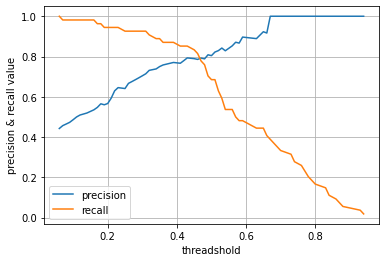

In [16]:
plt.plot(th, precision[:len(th)], label="precision")
plt.plot(th, recall[:len(th)], label="recall")
plt.xlabel("threadshold")
plt.ylabel("precision & recall value")
plt.legend() #plt.legend(["precision", "recall"])
plt.grid()
plt.show()

* 위의 정밀도-재현율 그래프를 통해 임계값이 약 0.47 정도 수준일 때, 정밀도와 재현율이 균형을 이루는 것을 알 수 있다.
* 이때 정밀도, 재현율은 0.8 정도이다.

### 5. roc_auc_curve : FPR / TPR 비율

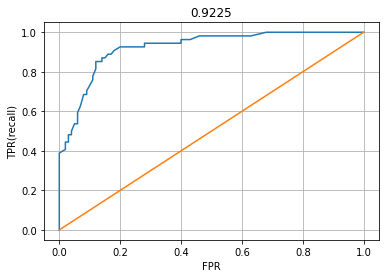

In [17]:
fpr, tpr, th = roc_curve(y_test, proba[:,1])
auc = roc_auc_score(y_test, proba[:, 1].reshape(-1, 1))
plt.plot(fpr, tpr, label='ROC')
plt.plot([0,1], [0,1], label='th:0.5')
plt.title(auc)
plt.xlabel("FPR")
plt.ylabel("TPR(recall)")
plt.grid()
plt.show()

* roc_auc_curve의 값이 0.9225가 나왔다. (1일때 가장 좋다.)

### 6. precision_recall_curve : 임계치 튜닝을 통한 점수 보정

In [19]:
my_th = [0.3, 0.33, 0.36, 0.39, 0.42, 0.45, 0.48, 0.50]

for th in my_th:
    print("N : P =", th, 1 - th)
    rf_model.fit(X_train, y_train)
    pred = rf_model.predict(X_test)
    proba = rf_model.predict_proba(X_test)
    get_score(y_test, pred)

    bn = Binarizer(threshold=th)
    # threshold = 임계치 / Binarizer는 0보다 크면 1 작으면 0 --> 임계치 조정해주는 함수
    fit_trans = bn.fit_transform(proba[:, 1].reshape(-1, 1))
    # proba[:,1]-> array 값으로 나오니까 다시 matrix로 바꾸기 위해 reshape 한다.
    # 임계치 올라가면 정밀도가 올라간다.
    auc = roc_auc_score(y_test, proba[:, 1].reshape(-1, 1))
    print(auc)
    print("------------------------------")

N : P = 0.3 0.7
정확도:0.8442, F1:0.7647 = (정밀도:0.7222 + 재현률:0.8125), roc-auc:0.8161
[[91  9]
 [15 39]]
0.9157407407407406
------------------------------
N : P = 0.33 0.6699999999999999
정확도:0.8182, F1:0.7083 = (정밀도:0.6296 + 재현률:0.8095), roc-auc:0.7748
[[92  8]
 [20 34]]
0.9199074074074074
------------------------------
N : P = 0.36 0.64
정확도:0.8312, F1:0.7400 = (정밀도:0.6852 + 재현률:0.8043), roc-auc:0.7976
[[91  9]
 [17 37]]
0.9149074074074074
------------------------------
N : P = 0.39 0.61
정확도:0.8247, F1:0.7273 = (정밀도:0.6667 + 재현률:0.8000), roc-auc:0.7883
[[91  9]
 [18 36]]
0.9207407407407407
------------------------------
N : P = 0.42 0.5800000000000001
정확도:0.7987, F1:0.6804 = (정밀도:0.6111 + 재현률:0.7674), roc-auc:0.7556
[[90 10]
 [21 33]]
0.9202777777777778
------------------------------
N : P = 0.45 0.55
정확도:0.8312, F1:0.7347 = (정밀도:0.6667 + 재현률:0.8182), roc-auc:0.7933
[[92  8]
 [18 36]]
0.9224074074074073
------------------------------
N : P = 0.48 0.52
정확도:0.8182, F1:0.7021 = (정밀도:0.6111 + 

정확도, 정밀도, 재현율, F1, AUC 등의 평가지표를 보고 판단 하였을 때, 임계치가 0.3일 때 개선도가 가장 큼을 알 수 있다.